# Bayesian Neural Network - Classification of drug stability



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

from tqdm import tqdm, tqdm_notebook

In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
# First, let's print the count for both of the classes
# 1 = stable ; 0 = unstable
#data['Stable_above_Tga'].value_counts()


### The data set contains 52 drugs which are either classified as stable (1) or unstable (0)

The amount of data is very small, but I till tried to classify the molecules with a Bayesian NN using stochastic variational inference in pytorch

In [4]:
# define the train and test data 
data = pd.read_csv('pyro_samples.csv')

X = data.drop('Stable_above_Tga', axis=1)
y = data['Stable_above_Tga']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train = X_train['CanonicalSMILES']
X_test = X_test['CanonicalSMILES']
# train = data[data.set == 'TR']
# X_train = train[['CanonicalSMILES']]
# y_train = train[['Stable_above_Tga']]

# test = data[data.set == 'TS']
# X_test = test[['CanonicalSMILES']]
# y_test = test[['Stable_above_Tga']]

#type(data['Stable_above_Tga'])

#train[['CanonicalSMILES']]

### The chemical molecules are depicted in their SMILES structure, embedded and vectorized to a 'molecule map' which serves as imput for the NN

### 

In [5]:
# embedding of SMILES
charset = set("".join(list(data.CanonicalSMILES))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.CanonicalSMILES]) + 5
print(str(charset))
print(len(charset), embed)

{'l', '(', 'F', 'S', ']', '7', '6', '4', '!', 'N', '5', '1', '-', 'P', '+', '[', 'E', 'O', ')', 'C', '2', '3', '#', '='}
24 103


In [7]:
# print the SMILES of the train data
X_train

5     CCCCCCCCCCCC(CC1C(C(=O)O1)CCCCCC)OC(=O)C(CC(C)...
16         C1=CC=C(C=C1)C2=COC3(C2=O)C4=CC=CC=C4C(=O)O3
28      CC12CCC(=O)C=C1CCC3C2C(CC4(C3CCC4(C(=O)CO)O)C)O
10                CCS(=O)(=O)CCN1C(=NC=C1[N+](=O)[O-])C
7     CCC(=C(C1=CC=CC=C1)C2=CC=C(C=C2)OCCN(C)C)C3=CC...
39    CC1=C(C2=C(C1=CC3=CC=C(C=C3)S(=O)C)C=CC(=C2)F)...
29                        CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
45            C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl
22      C1=CC(=CC=C1C(C(CO)NC(=O)C(Cl)Cl)O)[N+](=O)[O-]
30    CC1=C(C2=C(N1C(=O)C3=CC=C(C=C3)Cl)C=CC(=C2)OC)...
46    C1NC2=C(C=C(C(=C2)C(F)(F)F)S(=O)(=O)N)S(=O)(=O)N1
27    CCOC(=O)C1=C(NC(=C(C1C2=C(C(=CC=C2)Cl)Cl)C(=O)...
43    C1=CC=C(C(=C1)C(=O)OCC(CO)O)NC2=C3C=CC(=CC3=NC...
47    CC1=C(C(C(=C(N1)C)C(=O)OC(C)C)C2=CC=CC3=NON=C3...
4     CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2[N+](=O)[...
50    CS(=O)(=O)NC1=C(C=C(C=C1)[N+](=O)[O-])OC2=CC=C...
9                   CC12CCC3C(C1CCC2O)CCC4=CC(=O)CCC34C
49                   CC12CCC3C(C1CCC2O)CCC4=CC(=

### Below the SMILES and the molecule map of one drug are shown

In [6]:
X.head()

,Compound,CanonicalSMILES,Class,MW,Tm,DH,Tg,Tabove,Tg_Tabove,DG,Pi_AQc,F_AromB,HBondAcceptorCount,HBondDonorCount,HeavyAtomCount,TPSA,XLogP,set
0,Acetaminophen,CC(=O)NC1=CC=C(C=C1)O,0,151.2,443,29,299,319,0.94,5.9,0.48,0.55,2,2,11,49.3,0.5,TR
1,Celecoxib,CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)...,0,318.4,436,32,331,351,0.94,5.1,0.45,0.61,7,1,26,86.4,3.4,TR
2,Danazol,CC12CCC3C(C1CCC2(C#C)O)CCC4=CC5=C(CC34C)C=NO5,0,337.5,500,36,352,372,0.95,6.8,0.15,0.17,3,1,25,46.3,3.8,TR
3,Estradiol,CC12CCC3C(C1CCC2O)CCC4=C3C=CC(=C4)O,0,22.4,451,2,358,378,0.95,0.3,0.22,0.26,2,2,20,40.5,4.0,TR
4,Nifedipine,CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2[N+](=O)[...,0,346.3,446,39,320,340,0.94,7.0,1.00,0.23,7,1,25,110.0,2.2,TR


Drug name :  Orlistat
SMILES CCCCCCCCCCCC(CC1C(C(=O)O1)CCCCCC)OC(=O)C(CC(C)C)NC=O


(103, 24)

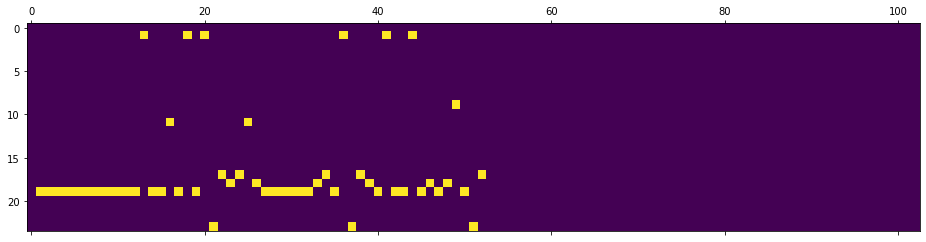

In [9]:
# define function to get one-hot encoded SMILES 
def vectorize(smiles):
    
    one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
    for i,smile in enumerate(smiles):
            #encode the startchar
        one_hot[i,0,char_to_int["!"]] = 0
            #encode the rest of the chars
        for j,c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 0
        #Return two, one for input and the other for output
    return one_hot

# get input samples for train and test
X_train_smiles = vectorize(X_train) 
X_test_smiles = vectorize(X_test)

# see if the vectorize function works
print('Drug name : ', X.Compound[5])
print('SMILES', X_train.iloc[0])
plt.matshow(X_train_smiles[0].T)
X_train_smiles[0].shape


# Bayesian NN 

In [9]:
# Define NN architechture 

class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size1, hidden_size2,   output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size1, hidden_size2)# changes
        self.out = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.fc2(output)
        output = F.relu(output)
        output = self.fc3(output)
        output = F.relu(output)
        output = self.out(output)
        return output.to(device)


In [10]:
y_train_target = torch.tensor(np.asanyarray(y_train), dtype = torch.float32)
#y_train_target.shape
train = torch.tensor(X_train_smiles.astype(np.float32), dtype = torch.float32) 
train_tensor = torch.utils.data.TensorDataset(train, y_train_target) 
train_loader = torch.utils.data.DataLoader(dataset = train_tensor,  shuffle = True)

y_test_target = torch.tensor(np.asanyarray(y_test), dtype = torch.float32)
#y_test_target = torch.tensor(y_test.values.astype(np.float32)).reshape(y_test.shape[0])
#y_train_target.shape
test = torch.tensor(X_test_smiles.astype(np.float32), dtype = torch.float32) 
test_tensor = torch.utils.data.TensorDataset(test, y_test_target) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor,  shuffle = True)

#type(y_train_target)
y_test_target.shape
#len(y_train_target)

torch.Size([16])

In [11]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


In [12]:
# Different functions which can be tested in the model
log_softmax = nn.LogSoftmax(dim=1)

softmax = nn.Softmax(dim=1)
sigmoid = nn.Sigmoid()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LogSigmoid = nn.LogSigmoid()


In [13]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    fc2w_prior = Normal(loc=torch.zeros_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight))
    fc2b_prior = Normal(loc=torch.zeros_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias))
    
    fc3w_prior = Normal(loc=torch.zeros_like(net.fc3.weight), scale=torch.ones_like(net.fc3.weight))
    fc3b_prior = Normal(loc=torch.zeros_like(net.fc3.bias), scale=torch.ones_like(net.fc3.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior, 'fc3.weight': fc3w_prior, 
              'fc3.bias': fc3b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior} # changes

    #priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,   'out.weight': outw_prior, 'out.bias': outb_prior} # changes
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = LogSigmoid(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data).to(device)



In [14]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    
    # Second layer weight distribution priors
    fc2w_mu = torch.randn_like(net.fc2.weight)
    fc2w_sigma = torch.randn_like(net.fc2.weight)
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2w_prior = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)
    # Second layer bias distribution priors
    fc2b_mu = torch.randn_like(net.fc2.bias)
    fc2b_sigma = torch.randn_like(net.fc2.bias)
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2b_prior = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)
    
    # Third layer weight distribution priors
    fc3w_mu = torch.randn_like(net.fc3.weight)
    fc3w_sigma = torch.randn_like(net.fc3.weight)
    fc3w_mu_param = pyro.param("fc3w_mu", fc3w_mu)
    fc3w_sigma_param = softplus(pyro.param("fc3w_sigma", fc3w_sigma))
    fc3w_prior = Normal(loc=fc3w_mu_param, scale=fc3w_sigma_param)
    # Third layer bias distribution priors
    fc3b_mu = torch.randn_like(net.fc3.bias).to(device)
    fc3b_sigma = torch.randn_like(net.fc3.bias).to(device)
    fc3b_mu_param = pyro.param("fc3b_mu", fc3b_mu).to(device)
    fc3b_sigma_param = softplus(pyro.param("fc3b_sigma", fc3b_sigma))
    fc3b_prior = Normal(loc=fc3b_mu_param, scale=fc3b_sigma_param)
    
    
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior, 'fc3.weight': fc3w_prior, 
              'fc3.bias': fc3b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    #priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior} # changes
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module().to(device)

In [15]:
net = NN(103*24, 100, 100,  2)
print(net)

NN(
  (fc1): Linear(in_features=2472, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=2, bias=True)
)


In [16]:
lr = 0.001
optim = Adam({"lr": lr}) # with 0.01 --> 76% accuracy with 2 layer (100nodes each)
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [17]:
#data[0].shape
#data[0].view(-1,103*24).shape
#data[1].shape
#type(data[1])
#outw_mu

# Training and prediction

In [22]:
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:0") # Uncomment this to run on GPU

num_iterations = 250
losses = []

for j in tqdm(range(num_iterations)):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,103*24), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    losses.append(total_epoch_loss_train)
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)




  0%|                                                                                          | 0/250 [00:00<?, ?it/s]

Epoch  0  Loss  50592.67449489236


  0%|▎                                                                                 | 1/250 [00:01<05:57,  1.44s/it]

Epoch  1  Loss  49367.995771070324


  1%|▋                                                                                 | 2/250 [00:03<06:09,  1.49s/it]

Epoch  2  Loss  47909.79402067926


  1%|▉                                                                                 | 3/250 [00:04<06:19,  1.53s/it]

Epoch  3  Loss  46714.08468133211


  2%|█▎                                                                                | 4/250 [00:06<06:26,  1.57s/it]

Epoch  4  Loss  45407.03857269221


  2%|█▋                                                                                | 5/250 [00:07<06:28,  1.59s/it]

Epoch  5  Loss  44178.277941948836


  2%|█▉                                                                                | 6/250 [00:09<06:30,  1.60s/it]

Epoch  6  Loss  43083.36316988534


  3%|██▎                                                                               | 7/250 [00:11<06:24,  1.58s/it]

Epoch  7  Loss  41968.961979816355


  3%|██▌                                                                               | 8/250 [00:12<06:19,  1.57s/it]

Epoch  8  Loss  40842.84106797642


  4%|██▉                                                                               | 9/250 [00:14<06:14,  1.55s/it]

Epoch  9  Loss  40068.5886621409


  4%|███▏                                                                             | 10/250 [00:15<06:15,  1.57s/it]

Epoch  10  Loss  38711.193115380076


  4%|███▌                                                                             | 11/250 [00:17<06:16,  1.57s/it]

Epoch  11  Loss  37807.86298848523


  5%|███▉                                                                             | 12/250 [00:18<06:14,  1.57s/it]

Epoch  12  Loss  36800.06384415759


  5%|████▏                                                                            | 13/250 [00:20<06:15,  1.59s/it]

Epoch  13  Loss  35831.1680396994


  6%|████▌                                                                            | 14/250 [00:22<06:13,  1.58s/it]

Epoch  14  Loss  35007.106675330135


  6%|████▊                                                                            | 15/250 [00:23<06:20,  1.62s/it]

Epoch  15  Loss  34206.377204851975


  6%|█████▏                                                                           | 16/250 [00:25<06:17,  1.61s/it]

Epoch  16  Loss  33287.5388676756


  7%|█████▌                                                                           | 17/250 [00:27<06:15,  1.61s/it]

Epoch  17  Loss  32406.377375831205


  7%|█████▊                                                                           | 18/250 [00:28<06:15,  1.62s/it]

Epoch  18  Loss  31586.378967911005


  8%|██████▏                                                                          | 19/250 [00:30<06:13,  1.62s/it]

Epoch  19  Loss  30972.09832060999


  8%|██████▍                                                                          | 20/250 [00:31<06:12,  1.62s/it]

Epoch  20  Loss  30165.47196705805


  8%|██████▊                                                                          | 21/250 [00:33<06:11,  1.62s/it]

Epoch  21  Loss  29559.742947492334


  9%|███████▏                                                                         | 22/250 [00:35<06:08,  1.62s/it]

Epoch  22  Loss  28801.675023552445


  9%|███████▍                                                                         | 23/250 [00:36<06:05,  1.61s/it]

Epoch  23  Loss  28067.441553884084


 10%|███████▊                                                                         | 24/250 [00:38<06:02,  1.61s/it]

Epoch  24  Loss  27399.523020048935


 10%|████████                                                                         | 25/250 [00:39<05:58,  1.59s/it]

Epoch  25  Loss  26764.90828646885


 10%|████████▍                                                                        | 26/250 [00:41<05:57,  1.60s/it]

Epoch  26  Loss  26168.53598578771


 11%|████████▋                                                                        | 27/250 [00:43<05:55,  1.59s/it]

Epoch  27  Loss  25456.698678599463


 11%|█████████                                                                        | 28/250 [00:44<05:54,  1.60s/it]

Epoch  28  Loss  24905.362832393912


 12%|█████████▍                                                                       | 29/250 [00:46<05:55,  1.61s/it]

Epoch  29  Loss  24251.731940137015


 12%|█████████▋                                                                       | 30/250 [00:47<05:55,  1.61s/it]

Epoch  30  Loss  23796.950710164176


 12%|██████████                                                                       | 31/250 [00:49<05:53,  1.61s/it]

Epoch  31  Loss  23209.20362637109


 13%|██████████▎                                                                      | 32/250 [00:51<05:51,  1.61s/it]

Epoch  32  Loss  22692.65444302228


 13%|██████████▋                                                                      | 33/250 [00:52<05:50,  1.62s/it]

Epoch  33  Loss  22415.461922695238


 14%|███████████                                                                      | 34/250 [00:54<05:47,  1.61s/it]

Epoch  34  Loss  21619.770534687574


 14%|███████████▎                                                                     | 35/250 [00:55<05:44,  1.60s/it]

Epoch  35  Loss  21120.12614948882


 14%|███████████▋                                                                     | 36/250 [00:57<05:39,  1.58s/it]

Epoch  36  Loss  20638.239257435005


 15%|███████████▉                                                                     | 37/250 [00:59<05:40,  1.60s/it]

Epoch  37  Loss  20201.3771871229


 15%|████████████▎                                                                    | 38/250 [01:00<05:37,  1.59s/it]

Epoch  38  Loss  19887.733394414186


 16%|████████████▋                                                                    | 39/250 [01:02<05:41,  1.62s/it]

Epoch  39  Loss  19349.56305546562


 16%|████████████▉                                                                    | 40/250 [01:04<05:46,  1.65s/it]

Epoch  40  Loss  18848.17407735851


 16%|█████████████▎                                                                   | 41/250 [01:05<05:40,  1.63s/it]

Epoch  41  Loss  18513.74572094944


 17%|█████████████▌                                                                   | 42/250 [01:07<05:37,  1.62s/it]

Epoch  42  Loss  18117.98804809981


 17%|█████████████▉                                                                   | 43/250 [01:08<05:37,  1.63s/it]

Epoch  43  Loss  17787.472447829114


 18%|██████████████▎                                                                  | 44/250 [01:10<05:33,  1.62s/it]

Epoch  44  Loss  17283.311682707732


 18%|██████████████▌                                                                  | 45/250 [01:12<05:31,  1.62s/it]

Epoch  45  Loss  16901.666555795404


 18%|██████████████▉                                                                  | 46/250 [01:13<05:29,  1.61s/it]

Epoch  46  Loss  16503.105839967728


 19%|███████████████▏                                                                 | 47/250 [01:15<05:28,  1.62s/it]

Epoch  47  Loss  16161.053259207143


 19%|███████████████▌                                                                 | 48/250 [01:17<05:26,  1.62s/it]

Epoch  48  Loss  15886.579952985048


 20%|███████████████▉                                                                 | 49/250 [01:18<05:26,  1.62s/it]

Epoch  49  Loss  15521.202571110593


 20%|████████████████▏                                                                | 50/250 [01:20<05:22,  1.61s/it]

Epoch  50  Loss  15201.064075132212


 20%|████████████████▌                                                                | 51/250 [01:21<05:21,  1.61s/it]

Epoch  51  Loss  14948.227825694614


 21%|████████████████▊                                                                | 52/250 [01:23<05:19,  1.61s/it]

Epoch  52  Loss  14539.69160967072


 21%|█████████████████▏                                                               | 53/250 [01:25<05:15,  1.60s/it]

Epoch  53  Loss  14253.566647807756


 22%|█████████████████▍                                                               | 54/250 [01:26<05:14,  1.60s/it]

Epoch  54  Loss  13951.277357521984


 22%|█████████████████▊                                                               | 55/250 [01:28<05:12,  1.60s/it]

Epoch  55  Loss  13644.27526454462


 22%|██████████████████▏                                                              | 56/250 [01:29<05:09,  1.59s/it]

Epoch  56  Loss  13327.117190198765


 23%|██████████████████▍                                                              | 57/250 [01:31<05:07,  1.59s/it]

Epoch  57  Loss  13050.935713648796


 23%|██████████████████▊                                                              | 58/250 [01:33<05:06,  1.60s/it]

Epoch  58  Loss  12861.014478610621


 24%|███████████████████                                                              | 59/250 [01:34<05:03,  1.59s/it]

Epoch  59  Loss  12528.699005878634


 24%|███████████████████▍                                                             | 60/250 [01:36<05:02,  1.59s/it]

Epoch  60  Loss  12399.926418254772


 24%|███████████████████▊                                                             | 61/250 [01:37<05:02,  1.60s/it]

Epoch  61  Loss  12026.177073809835


 25%|████████████████████                                                             | 62/250 [01:39<05:01,  1.60s/it]

Epoch  62  Loss  11722.2772266931


 25%|████████████████████▍                                                            | 63/250 [01:41<05:00,  1.61s/it]

Epoch  63  Loss  11493.241376694707


 26%|████████████████████▋                                                            | 64/250 [01:42<04:59,  1.61s/it]

Epoch  64  Loss  11270.253381248978


 26%|█████████████████████                                                            | 65/250 [01:44<04:57,  1.61s/it]

Epoch  65  Loss  11035.637306584253


 26%|█████████████████████▍                                                           | 66/250 [01:45<04:53,  1.60s/it]

Epoch  66  Loss  10793.518522398339


 27%|█████████████████████▋                                                           | 67/250 [01:47<04:52,  1.60s/it]

Epoch  67  Loss  10571.865573740668


 27%|██████████████████████                                                           | 68/250 [01:49<04:50,  1.60s/it]

Epoch  68  Loss  10363.469667024083


 28%|██████████████████████▎                                                          | 69/250 [01:50<04:49,  1.60s/it]

Epoch  69  Loss  10149.33841075831


 28%|██████████████████████▋                                                          | 70/250 [01:52<04:45,  1.59s/it]

Epoch  70  Loss  9925.235491514206


 28%|███████████████████████                                                          | 71/250 [01:53<04:46,  1.60s/it]

Epoch  71  Loss  9728.738137337896


 29%|███████████████████████▎                                                         | 72/250 [01:55<04:45,  1.60s/it]

Epoch  72  Loss  9468.80087252458


 29%|███████████████████████▋                                                         | 73/250 [01:57<04:43,  1.60s/it]

Epoch  73  Loss  9311.063857035504


 30%|███████████████████████▉                                                         | 74/250 [01:58<04:40,  1.59s/it]

Epoch  74  Loss  9184.279255525933


 30%|████████████████████████▎                                                        | 75/250 [02:00<04:39,  1.60s/it]

Epoch  75  Loss  8967.496087127261


 30%|████████████████████████▌                                                        | 76/250 [02:01<04:41,  1.62s/it]

Epoch  76  Loss  8778.29000863764


 31%|████████████████████████▉                                                        | 77/250 [02:03<04:45,  1.65s/it]

Epoch  77  Loss  8604.901339587239


 31%|█████████████████████████▎                                                       | 78/250 [02:05<04:44,  1.65s/it]

Epoch  78  Loss  8381.042172143856


 32%|█████████████████████████▌                                                       | 79/250 [02:06<04:40,  1.64s/it]

Epoch  79  Loss  8217.776505132517


 32%|█████████████████████████▉                                                       | 80/250 [02:08<04:51,  1.71s/it]

Epoch  80  Loss  7998.874066117737


 32%|██████████████████████████▏                                                      | 81/250 [02:10<05:03,  1.80s/it]

Epoch  81  Loss  7884.038772026698


 33%|██████████████████████████▌                                                      | 82/250 [02:12<05:07,  1.83s/it]

Epoch  82  Loss  7678.1143713163


 33%|██████████████████████████▉                                                      | 83/250 [02:14<05:20,  1.92s/it]

Epoch  83  Loss  7526.410462690725


 34%|███████████████████████████▏                                                     | 84/250 [02:16<05:23,  1.95s/it]

Epoch  84  Loss  7375.493686861462


 34%|███████████████████████████▌                                                     | 85/250 [02:18<05:28,  1.99s/it]

Epoch  85  Loss  7228.52407418357


 34%|███████████████████████████▊                                                     | 86/250 [02:20<05:31,  2.02s/it]

Epoch  86  Loss  7117.390075862408


 35%|████████████████████████████▏                                                    | 87/250 [02:23<05:31,  2.03s/it]

Epoch  87  Loss  6885.011182867818


 35%|████████████████████████████▌                                                    | 88/250 [02:25<05:30,  2.04s/it]

Epoch  88  Loss  6765.185376607709


 36%|████████████████████████████▊                                                    | 89/250 [02:27<05:21,  2.00s/it]

Epoch  89  Loss  6590.443066143327


 36%|█████████████████████████████▏                                                   | 90/250 [02:28<05:15,  1.97s/it]

Epoch  90  Loss  6455.038987888231


 36%|█████████████████████████████▍                                                   | 91/250 [02:30<05:04,  1.92s/it]

Epoch  91  Loss  6308.628849556048


 37%|█████████████████████████████▊                                                   | 92/250 [02:32<04:50,  1.84s/it]

Epoch  92  Loss  6198.543299545844


 37%|██████████████████████████████▏                                                  | 93/250 [02:34<04:42,  1.80s/it]

Epoch  93  Loss  6082.366039103932


 38%|██████████████████████████████▍                                                  | 94/250 [02:35<04:34,  1.76s/it]

Epoch  94  Loss  5907.3397200041345


 38%|██████████████████████████████▊                                                  | 95/250 [02:37<04:30,  1.75s/it]

Epoch  95  Loss  5778.239165421989


 38%|███████████████████████████████                                                  | 96/250 [02:39<04:23,  1.71s/it]

Epoch  96  Loss  5651.1271485156485


 39%|███████████████████████████████▍                                                 | 97/250 [02:40<04:18,  1.69s/it]

Epoch  97  Loss  5536.74007066422


 39%|███████████████████████████████▊                                                 | 98/250 [02:42<04:18,  1.70s/it]

Epoch  98  Loss  5482.15088342958


 40%|████████████████████████████████                                                 | 99/250 [02:44<04:14,  1.68s/it]

Epoch  99  Loss  5319.852442403634


 40%|████████████████████████████████                                                | 100/250 [02:45<04:12,  1.68s/it]

Epoch  100  Loss  5191.117889851332


 40%|████████████████████████████████▎                                               | 101/250 [02:47<04:08,  1.67s/it]

Epoch  101  Loss  5092.73747052749


 41%|████████████████████████████████▋                                               | 102/250 [02:49<04:05,  1.66s/it]

Epoch  102  Loss  4982.287543929286


 41%|████████████████████████████████▉                                               | 103/250 [02:50<04:03,  1.66s/it]

Epoch  103  Loss  4848.689707275894


 42%|█████████████████████████████████▎                                              | 104/250 [02:52<04:00,  1.65s/it]

Epoch  104  Loss  4745.855056858725


 42%|█████████████████████████████████▌                                              | 105/250 [02:53<03:58,  1.65s/it]

Epoch  105  Loss  4619.439262727897


 42%|█████████████████████████████████▉                                              | 106/250 [02:55<03:58,  1.66s/it]

Epoch  106  Loss  4559.938159565131


 43%|██████████████████████████████████▏                                             | 107/250 [02:57<03:54,  1.64s/it]

Epoch  107  Loss  4448.137427694268


 43%|██████████████████████████████████▌                                             | 108/250 [02:58<03:50,  1.62s/it]

Epoch  108  Loss  4335.121565620105


 44%|██████████████████████████████████▉                                             | 109/250 [03:00<03:50,  1.64s/it]

Epoch  109  Loss  4301.990897158782


 44%|███████████████████████████████████▏                                            | 110/250 [03:02<03:48,  1.63s/it]

Epoch  110  Loss  4169.438509056966


 44%|███████████████████████████████████▌                                            | 111/250 [03:03<03:45,  1.62s/it]

Epoch  111  Loss  4063.396881358491


 45%|███████████████████████████████████▊                                            | 112/250 [03:05<03:47,  1.65s/it]

Epoch  112  Loss  3995.73168844978


 45%|████████████████████████████████████▏                                           | 113/250 [03:07<03:51,  1.69s/it]

Epoch  113  Loss  3888.4674361745515


 46%|████████████████████████████████████▍                                           | 114/250 [03:08<03:51,  1.70s/it]

Epoch  114  Loss  3793.0687464839884


 46%|████████████████████████████████████▊                                           | 115/250 [03:10<03:51,  1.71s/it]

Epoch  115  Loss  3742.972754329443


 46%|█████████████████████████████████████                                           | 116/250 [03:12<03:54,  1.75s/it]

Epoch  116  Loss  3643.3167164325714


 47%|█████████████████████████████████████▍                                          | 117/250 [03:14<03:57,  1.78s/it]

Epoch  117  Loss  3551.2889725201658


 47%|█████████████████████████████████████▊                                          | 118/250 [03:15<03:47,  1.73s/it]

Epoch  118  Loss  3488.5879489514564


 48%|██████████████████████████████████████                                          | 119/250 [03:17<03:45,  1.72s/it]

Epoch  119  Loss  3397.294742554426


 48%|██████████████████████████████████████▍                                         | 120/250 [03:19<03:39,  1.69s/it]

Epoch  120  Loss  3330.690551602178


 48%|██████████████████████████████████████▋                                         | 121/250 [03:20<03:35,  1.67s/it]

Epoch  121  Loss  3270.9802029265297


 49%|███████████████████████████████████████                                         | 122/250 [03:22<03:32,  1.66s/it]

Epoch  122  Loss  3193.556335128016


 49%|███████████████████████████████████████▎                                        | 123/250 [03:24<03:28,  1.64s/it]

Epoch  123  Loss  3140.0734651651646


 50%|███████████████████████████████████████▋                                        | 124/250 [03:25<03:25,  1.63s/it]

Epoch  124  Loss  3059.295515709453


 50%|████████████████████████████████████████                                        | 125/250 [03:27<03:23,  1.63s/it]

Epoch  125  Loss  2960.088402165307


 50%|████████████████████████████████████████▎                                       | 126/250 [03:29<03:22,  1.63s/it]

Epoch  126  Loss  3105.30776798394


 51%|████████████████████████████████████████▋                                       | 127/250 [03:30<03:22,  1.65s/it]

Epoch  127  Loss  2870.134699039989


 51%|████████████████████████████████████████▉                                       | 128/250 [03:32<03:18,  1.63s/it]

Epoch  128  Loss  2783.0467802253033


 52%|█████████████████████████████████████████▎                                      | 129/250 [03:33<03:18,  1.64s/it]

Epoch  129  Loss  2719.0532978574433


 52%|█████████████████████████████████████████▌                                      | 130/250 [03:35<03:21,  1.68s/it]

Epoch  130  Loss  2660.6884673469594


 52%|█████████████████████████████████████████▉                                      | 131/250 [03:37<03:25,  1.72s/it]

Epoch  131  Loss  2573.921237581306


 53%|██████████████████████████████████████████▏                                     | 132/250 [03:39<03:25,  1.74s/it]

Epoch  132  Loss  2525.6565595401657


 53%|██████████████████████████████████████████▌                                     | 133/250 [03:41<03:25,  1.75s/it]

Epoch  133  Loss  2496.294583539168


 54%|██████████████████████████████████████████▉                                     | 134/250 [03:42<03:24,  1.77s/it]

Epoch  134  Loss  2422.6624664366245


 54%|███████████████████████████████████████████▏                                    | 135/250 [03:44<03:23,  1.77s/it]

Epoch  135  Loss  2394.2994819018577


 54%|███████████████████████████████████████████▌                                    | 136/250 [03:46<03:21,  1.77s/it]

Epoch  136  Loss  2327.961261504226


 55%|███████████████████████████████████████████▊                                    | 137/250 [03:48<03:14,  1.72s/it]

Epoch  137  Loss  2306.5324760344292


 55%|████████████████████████████████████████████▏                                   | 138/250 [03:49<03:10,  1.70s/it]

Epoch  138  Loss  2216.2295946876206


 56%|████████████████████████████████████████████▍                                   | 139/250 [03:51<03:05,  1.67s/it]

Epoch  139  Loss  2182.3876656492553


 56%|████████████████████████████████████████████▊                                   | 140/250 [03:52<03:02,  1.66s/it]

Epoch  140  Loss  2155.9021877381538


 56%|█████████████████████████████████████████████                                   | 141/250 [03:54<02:59,  1.65s/it]

Epoch  141  Loss  2099.886680930853


 57%|█████████████████████████████████████████████▍                                  | 142/250 [03:56<02:59,  1.66s/it]

Epoch  142  Loss  2008.3446502188842


 57%|█████████████████████████████████████████████▊                                  | 143/250 [03:57<02:57,  1.66s/it]

Epoch  143  Loss  1958.2034853961732


 58%|██████████████████████████████████████████████                                  | 144/250 [03:59<02:57,  1.67s/it]

Epoch  144  Loss  1939.3151828977798


 58%|██████████████████████████████████████████████▍                                 | 145/250 [04:01<02:56,  1.68s/it]

Epoch  145  Loss  1981.2389685975181


 58%|██████████████████████████████████████████████▋                                 | 146/250 [04:03<03:17,  1.90s/it]

Epoch  146  Loss  1847.7250815166367


 59%|███████████████████████████████████████████████                                 | 147/250 [04:05<03:14,  1.89s/it]

Epoch  147  Loss  1807.7052744627


 59%|███████████████████████████████████████████████▎                                | 148/250 [04:07<03:07,  1.84s/it]

Epoch  148  Loss  1764.6962924963898


 60%|███████████████████████████████████████████████▋                                | 149/250 [04:09<03:12,  1.90s/it]

Epoch  149  Loss  1749.7635120683246


 60%|████████████████████████████████████████████████                                | 150/250 [04:11<03:30,  2.11s/it]

Epoch  150  Loss  1692.202304939429


 60%|████████████████████████████████████████████████▎                               | 151/250 [04:13<03:24,  2.07s/it]

Epoch  151  Loss  1646.910530358553


 61%|████████████████████████████████████████████████▋                               | 152/250 [04:15<03:13,  1.98s/it]

Epoch  152  Loss  1663.5076664421294


 61%|████████████████████████████████████████████████▉                               | 153/250 [04:17<03:05,  1.92s/it]

Epoch  153  Loss  1612.9372576144006


 62%|█████████████████████████████████████████████████▎                              | 154/250 [04:19<02:59,  1.87s/it]

Epoch  154  Loss  1559.4624378648068


 62%|█████████████████████████████████████████████████▌                              | 155/250 [04:20<02:52,  1.82s/it]

Epoch  155  Loss  1514.7470176815987


 62%|█████████████████████████████████████████████████▉                              | 156/250 [04:22<02:48,  1.79s/it]

Epoch  156  Loss  1496.6028761002754


 63%|██████████████████████████████████████████████████▏                             | 157/250 [04:24<02:44,  1.77s/it]

Epoch  157  Loss  1472.9708023369312


 63%|██████████████████████████████████████████████████▌                             | 158/250 [04:26<02:39,  1.74s/it]

Epoch  158  Loss  1441.1226302418445


 64%|██████████████████████████████████████████████████▉                             | 159/250 [04:27<02:35,  1.71s/it]

Epoch  159  Loss  1439.1984296407963


 64%|███████████████████████████████████████████████████▏                            | 160/250 [04:29<02:32,  1.69s/it]

Epoch  160  Loss  1372.191217213869


 64%|███████████████████████████████████████████████████▌                            | 161/250 [04:31<02:30,  1.69s/it]

Epoch  161  Loss  1339.0461069146793


 65%|███████████████████████████████████████████████████▊                            | 162/250 [04:32<02:29,  1.70s/it]

Epoch  162  Loss  1313.1405594382022


 65%|████████████████████████████████████████████████████▏                           | 163/250 [04:34<02:30,  1.73s/it]

Epoch  163  Loss  1278.303937021229


 66%|████████████████████████████████████████████████████▍                           | 164/250 [04:36<02:32,  1.77s/it]

Epoch  164  Loss  1268.309171565705


 66%|████████████████████████████████████████████████████▊                           | 165/250 [04:38<02:35,  1.83s/it]

Epoch  165  Loss  1242.1739674243663


 66%|█████████████████████████████████████████████████████                           | 166/250 [04:40<02:34,  1.84s/it]

Epoch  166  Loss  1258.4273571206463


 67%|█████████████████████████████████████████████████████▍                          | 167/250 [04:42<02:37,  1.89s/it]

Epoch  167  Loss  1173.625724726253


 67%|█████████████████████████████████████████████████████▊                          | 168/250 [04:45<03:01,  2.22s/it]

Epoch  168  Loss  1173.9690136081642


 68%|██████████████████████████████████████████████████████                          | 169/250 [04:47<02:50,  2.10s/it]

Epoch  169  Loss  1135.276121953968


 68%|██████████████████████████████████████████████████████▍                         | 170/250 [04:49<02:44,  2.06s/it]

Epoch  170  Loss  1115.3161392476823


 68%|██████████████████████████████████████████████████████▋                         | 171/250 [04:50<02:36,  1.98s/it]

Epoch  171  Loss  1087.5756286945607


 69%|███████████████████████████████████████████████████████                         | 172/250 [04:52<02:28,  1.91s/it]

Epoch  172  Loss  1077.805822475089


 69%|███████████████████████████████████████████████████████▎                        | 173/250 [04:54<02:23,  1.87s/it]

Epoch  173  Loss  1047.0949316687054


 70%|███████████████████████████████████████████████████████▋                        | 174/250 [04:56<02:22,  1.88s/it]

Epoch  174  Loss  1024.844379261136


 70%|████████████████████████████████████████████████████████                        | 175/250 [04:58<02:21,  1.89s/it]

Epoch  175  Loss  1014.2936619023482


 70%|████████████████████████████████████████████████████████▎                       | 176/250 [04:59<02:16,  1.85s/it]

Epoch  176  Loss  983.0131514734692


 71%|████████████████████████████████████████████████████████▋                       | 177/250 [05:01<02:10,  1.79s/it]

Epoch  177  Loss  963.975180791484


 71%|████████████████████████████████████████████████████████▉                       | 178/250 [05:03<02:10,  1.81s/it]

Epoch  178  Loss  936.534587075313


 72%|█████████████████████████████████████████████████████████▎                      | 179/250 [05:05<02:07,  1.80s/it]

Epoch  179  Loss  959.3121332923571


 72%|█████████████████████████████████████████████████████████▌                      | 180/250 [05:06<02:04,  1.78s/it]

Epoch  180  Loss  927.1033739613163


 72%|█████████████████████████████████████████████████████████▉                      | 181/250 [05:08<02:01,  1.76s/it]

Epoch  181  Loss  903.0333212647173


 73%|██████████████████████████████████████████████████████████▏                     | 182/250 [05:10<01:58,  1.74s/it]

Epoch  182  Loss  870.2571292585797


 73%|██████████████████████████████████████████████████████████▌                     | 183/250 [05:12<01:55,  1.73s/it]

Epoch  183  Loss  877.8316996693611


 74%|██████████████████████████████████████████████████████████▉                     | 184/250 [05:13<01:53,  1.73s/it]

Epoch  184  Loss  859.2297108736303


 74%|███████████████████████████████████████████████████████████▏                    | 185/250 [05:15<01:51,  1.71s/it]

Epoch  185  Loss  838.5346244076887


 74%|███████████████████████████████████████████████████████████▌                    | 186/250 [05:17<01:50,  1.72s/it]

Epoch  186  Loss  825.5967933601803


 75%|███████████████████████████████████████████████████████████▊                    | 187/250 [05:19<02:04,  1.97s/it]

Epoch  187  Loss  810.3832464052571


 75%|████████████████████████████████████████████████████████████▏                   | 188/250 [05:21<02:03,  1.99s/it]

Epoch  188  Loss  785.5936211546262


 76%|████████████████████████████████████████████████████████████▍                   | 189/250 [05:23<01:58,  1.94s/it]

Epoch  189  Loss  778.5989463163746


 76%|████████████████████████████████████████████████████████████▊                   | 190/250 [05:25<01:54,  1.90s/it]

Epoch  190  Loss  767.5718648499912


 76%|█████████████████████████████████████████████████████████████                   | 191/250 [05:27<01:51,  1.89s/it]

Epoch  191  Loss  750.5088221530119


 77%|█████████████████████████████████████████████████████████████▍                  | 192/250 [05:29<01:49,  1.88s/it]

Epoch  192  Loss  744.7050953143173


 77%|█████████████████████████████████████████████████████████████▊                  | 193/250 [05:30<01:46,  1.87s/it]

Epoch  193  Loss  719.9136274821228


 78%|██████████████████████████████████████████████████████████████                  | 194/250 [05:32<01:46,  1.90s/it]

Epoch  194  Loss  702.9047751625379


 78%|██████████████████████████████████████████████████████████████▍                 | 195/250 [05:35<01:48,  1.98s/it]

Epoch  195  Loss  719.5082538111342


 78%|██████████████████████████████████████████████████████████████▋                 | 196/250 [05:36<01:45,  1.95s/it]

Epoch  196  Loss  698.5807915528616


 79%|███████████████████████████████████████████████████████████████                 | 197/250 [05:38<01:42,  1.94s/it]

Epoch  197  Loss  679.5818998879856


 79%|███████████████████████████████████████████████████████████████▎                | 198/250 [05:40<01:39,  1.92s/it]

Epoch  198  Loss  657.3285465439161


 80%|███████████████████████████████████████████████████████████████▋                | 199/250 [05:42<01:38,  1.92s/it]

Epoch  199  Loss  645.9767688148552


 80%|████████████████████████████████████████████████████████████████                | 200/250 [05:44<01:39,  1.99s/it]

Epoch  200  Loss  634.2891130215592


 80%|████████████████████████████████████████████████████████████████▎               | 201/250 [05:46<01:37,  1.98s/it]

Epoch  201  Loss  624.7262663278315


 81%|████████████████████████████████████████████████████████████████▋               | 202/250 [05:48<01:34,  1.97s/it]

Epoch  202  Loss  612.060699313879


 81%|████████████████████████████████████████████████████████████████▉               | 203/250 [05:50<01:29,  1.90s/it]

Epoch  203  Loss  606.1859057711231


 82%|█████████████████████████████████████████████████████████████████▎              | 204/250 [05:52<01:26,  1.88s/it]

Epoch  204  Loss  594.3480812244945


 82%|█████████████████████████████████████████████████████████████████▌              | 205/250 [05:54<01:24,  1.88s/it]

Epoch  205  Loss  587.0198552641604


 82%|█████████████████████████████████████████████████████████████████▉              | 206/250 [05:55<01:21,  1.85s/it]

Epoch  206  Loss  579.0070728262266


 83%|██████████████████████████████████████████████████████████████████▏             | 207/250 [05:57<01:17,  1.81s/it]

Epoch  207  Loss  564.9082959493002


 83%|██████████████████████████████████████████████████████████████████▌             | 208/250 [05:59<01:15,  1.79s/it]

Epoch  208  Loss  554.8146552377277


 84%|██████████████████████████████████████████████████████████████████▉             | 209/250 [06:01<01:13,  1.78s/it]

Epoch  209  Loss  547.1340221133497


 84%|███████████████████████████████████████████████████████████████████▏            | 210/250 [06:03<01:13,  1.83s/it]

Epoch  210  Loss  541.9250365661251


 84%|███████████████████████████████████████████████████████████████████▌            | 211/250 [06:04<01:11,  1.82s/it]

Epoch  211  Loss  522.8414469361305


 85%|███████████████████████████████████████████████████████████████████▊            | 212/250 [06:06<01:07,  1.78s/it]

Epoch  212  Loss  516.1620888411999


 85%|████████████████████████████████████████████████████████████████████▏           | 213/250 [06:08<01:04,  1.74s/it]

Epoch  213  Loss  529.3847888476319


 86%|████████████████████████████████████████████████████████████████████▍           | 214/250 [06:09<01:02,  1.73s/it]

Epoch  214  Loss  506.6383227739069


 86%|████████████████████████████████████████████████████████████████████▊           | 215/250 [06:11<01:00,  1.71s/it]

Epoch  215  Loss  504.5184131628937


 86%|█████████████████████████████████████████████████████████████████████           | 216/250 [06:13<00:58,  1.71s/it]

Epoch  216  Loss  489.7897395557827


 87%|█████████████████████████████████████████████████████████████████████▍          | 217/250 [06:15<00:56,  1.70s/it]

Epoch  217  Loss  475.7388235165013


 87%|█████████████████████████████████████████████████████████████████████▊          | 218/250 [06:16<00:54,  1.69s/it]

Epoch  218  Loss  463.6130795478821


 88%|██████████████████████████████████████████████████████████████████████          | 219/250 [06:18<00:52,  1.68s/it]

Epoch  219  Loss  462.48294260435637


 88%|██████████████████████████████████████████████████████████████████████▍         | 220/250 [06:20<00:50,  1.69s/it]

Epoch  220  Loss  451.64214823312227


 88%|██████████████████████████████████████████████████████████████████████▋         | 221/250 [06:21<00:48,  1.68s/it]

Epoch  221  Loss  448.3290247619152


 89%|███████████████████████████████████████████████████████████████████████         | 222/250 [06:23<00:47,  1.69s/it]

Epoch  222  Loss  436.2543242043919


 89%|███████████████████████████████████████████████████████████████████████▎        | 223/250 [06:25<00:45,  1.69s/it]

Epoch  223  Loss  425.1685841447777


 90%|███████████████████████████████████████████████████████████████████████▋        | 224/250 [06:26<00:43,  1.68s/it]

Epoch  224  Loss  483.7009123928017


 90%|████████████████████████████████████████████████████████████████████████        | 225/250 [06:28<00:42,  1.69s/it]

Epoch  225  Loss  418.34239967332945


 90%|████████████████████████████████████████████████████████████████████████▎       | 226/250 [06:30<00:40,  1.69s/it]

Epoch  226  Loss  447.9913803239663


 91%|████████████████████████████████████████████████████████████████████████▋       | 227/250 [06:31<00:38,  1.68s/it]

Epoch  227  Loss  409.6182978153229


 91%|████████████████████████████████████████████████████████████████████████▉       | 228/250 [06:33<00:37,  1.68s/it]

Epoch  228  Loss  401.47358310222626


 92%|█████████████████████████████████████████████████████████████████████████▎      | 229/250 [06:35<00:35,  1.69s/it]

Epoch  229  Loss  393.38523900177745


 92%|█████████████████████████████████████████████████████████████████████████▌      | 230/250 [06:36<00:33,  1.69s/it]

Epoch  230  Loss  396.78026491072444


 92%|█████████████████████████████████████████████████████████████████████████▉      | 231/250 [06:38<00:32,  1.69s/it]

Epoch  231  Loss  394.80170583062704


 93%|██████████████████████████████████████████████████████████████████████████▏     | 232/250 [06:40<00:30,  1.69s/it]

Epoch  232  Loss  383.09896285997496


 93%|██████████████████████████████████████████████████████████████████████████▌     | 233/250 [06:42<00:28,  1.69s/it]

Epoch  233  Loss  375.48226175705594


 94%|██████████████████████████████████████████████████████████████████████████▉     | 234/250 [06:43<00:27,  1.69s/it]

Epoch  234  Loss  380.8404759532875


 94%|███████████████████████████████████████████████████████████████████████████▏    | 235/250 [06:45<00:25,  1.70s/it]

Epoch  235  Loss  370.3373646007644


 94%|███████████████████████████████████████████████████████████████████████████▌    | 236/250 [06:47<00:23,  1.69s/it]

Epoch  236  Loss  364.14108854201106


 95%|███████████████████████████████████████████████████████████████████████████▊    | 237/250 [06:48<00:21,  1.68s/it]

Epoch  237  Loss  406.4876546230581


 95%|████████████████████████████████████████████████████████████████████████████▏   | 238/250 [06:50<00:20,  1.68s/it]

Epoch  238  Loss  348.1625597741869


 96%|████████████████████████████████████████████████████████████████████████████▍   | 239/250 [06:52<00:18,  1.68s/it]

Epoch  239  Loss  373.81335162454184


 96%|████████████████████████████████████████████████████████████████████████████▊   | 240/250 [06:53<00:16,  1.69s/it]

Epoch  240  Loss  354.39344605472354


 96%|█████████████████████████████████████████████████████████████████████████████   | 241/250 [06:55<00:15,  1.68s/it]

Epoch  241  Loss  346.1221500701374


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 242/250 [06:57<00:13,  1.67s/it]

Epoch  242  Loss  444.3474835289849


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 243/250 [06:58<00:11,  1.67s/it]

Epoch  243  Loss  334.57244890265997


 98%|██████████████████████████████████████████████████████████████████████████████  | 244/250 [07:00<00:10,  1.67s/it]

Epoch  244  Loss  340.21334935724735


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 245/250 [07:02<00:08,  1.68s/it]

Epoch  245  Loss  333.79622994528876


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 246/250 [07:03<00:06,  1.69s/it]

Epoch  246  Loss  329.4506158795622


 99%|███████████████████████████████████████████████████████████████████████████████ | 247/250 [07:05<00:05,  1.68s/it]

Epoch  247  Loss  333.63163105977907


 99%|███████████████████████████████████████████████████████████████████████████████▎| 248/250 [07:07<00:03,  1.68s/it]

Epoch  248  Loss  312.6359374390708


100%|███████████████████████████████████████████████████████████████████████████████▋| 249/250 [07:08<00:01,  1.69s/it]

Epoch  249  Loss  331.44067185786037


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [07:10<00:00,  1.69s/it]


Text(0.5, 1.0, 'ELBO')

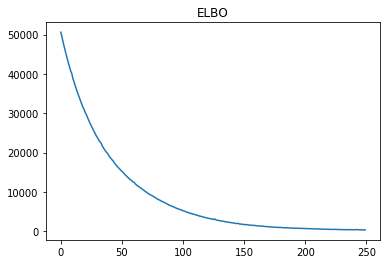

In [23]:
plt.plot(losses)
plt.title('ELBO')

Predicting test data ------------------------------------------


0it [00:00, ?it/s]

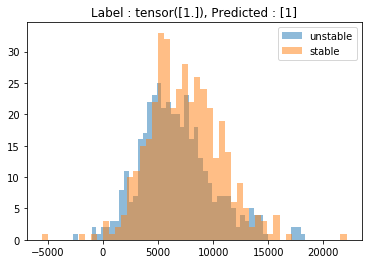

1it [00:06,  6.86s/it]

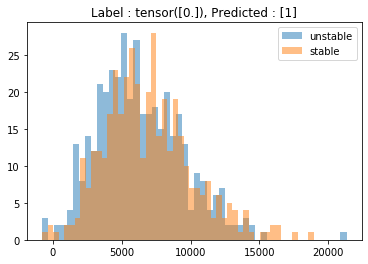

2it [00:14,  7.06s/it]

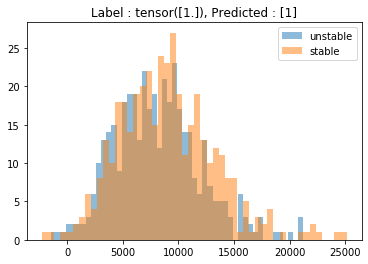

3it [00:21,  7.11s/it]

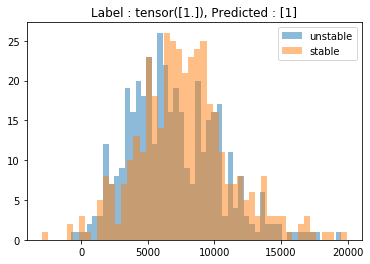

4it [00:28,  7.12s/it]

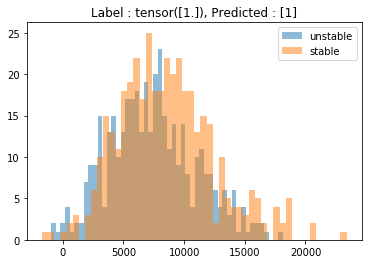

5it [00:35,  7.06s/it]

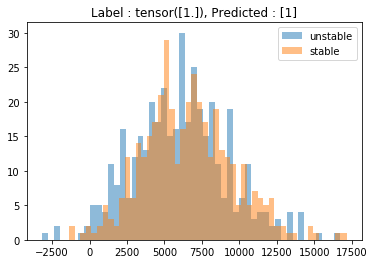

6it [00:42,  7.03s/it]

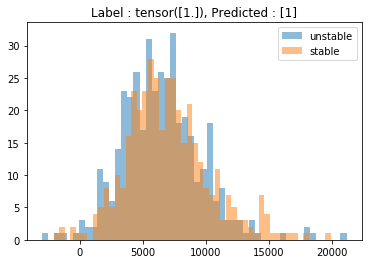

7it [00:49,  7.00s/it]

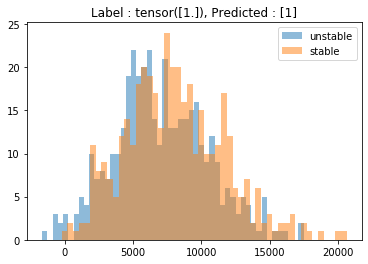

8it [00:56,  7.08s/it]

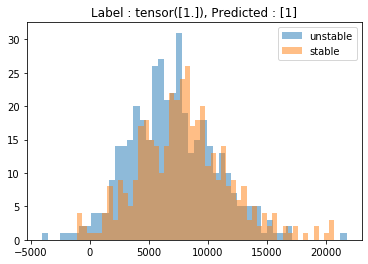

9it [01:03,  7.02s/it]

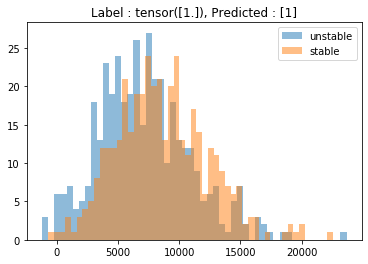

10it [01:10,  6.98s/it]

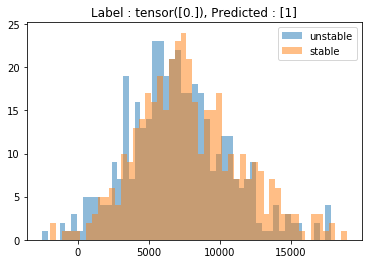

11it [01:19,  7.60s/it]

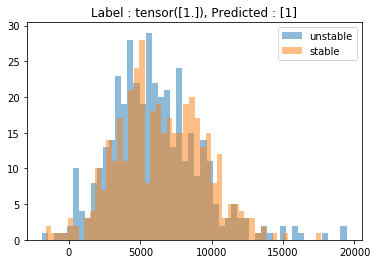

12it [01:28,  8.07s/it]

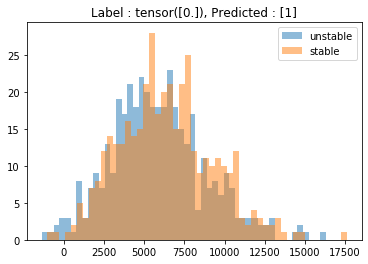

13it [01:35,  7.77s/it]

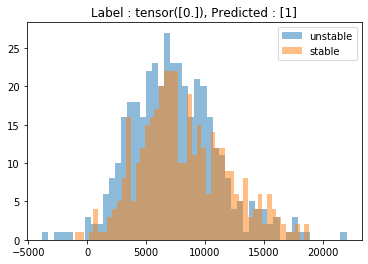

14it [01:42,  7.54s/it]

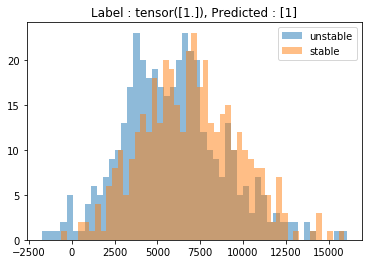

15it [01:49,  7.38s/it]

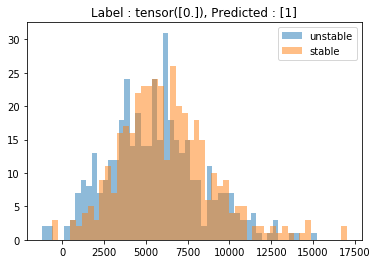

16it [01:56,  7.28s/it]


Done predicting -----------------------------------------------------
accuracy: 0.6875


In [27]:
num_samples = 400
def predict(x):
    sampled_models = [guide(None, None).to(device) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1), yhats
    #return mean

# def predict(x):
#     sampled_models = [guide(None, None) for _ in range(num_samples)]
#     yhats = [model(x).data for model in sampled_models]
#     mean = torch.mean(torch.stack(yhats), 0)
#     return np.argmax(mean, axis=1), yhats
    

# def give_uncertainities(x):
#     sampled_models = [guide(None, None) for _ in range(num_samples)]
#     yhats = [F.sigmoid(model(x.view(-1,103*24)).data).detach().numpy() for model in sampled_models]
#     return np.asarray(yhats)
    
#print('Predicting train data ------------------------------------------')
# correct = 0
# total = 0

# for j, data in enumerate(test_loader):
#     images, labels = data
#     predicted, y_hats = predict(images.view(-1,103*24).to(device))
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()
# print("accuracy: %d %%" % (100 * correct / total))

print('Predicting test data ------------------------------------------')

correct = 0
total = 0
y_preds = []
y_trues = []

for j, data in tqdm(enumerate(test_loader)):
    images, labels = data
    y_trues.append(labels.item())
    predicted, y_hats = predict(images.view(-1,103*24))
    y_preds.append(predicted.item())
    
    
    y_hats2 = torch.stack(y_hats).numpy().reshape(num_samples,2)

    plt.hist(y_hats2[:,0], alpha=0.5, label='unstable', bins=50)
    plt.hist(y_hats2[:,1], alpha=0.5, label = 'stable', bins=50)
    plt.title('Label : {}, Predicted : {}'.format(labels, predicted))
    

    plt.legend(['unstable', 'stable'])
    plt.show()
#     total += labels.size(0)
#     correct += (predicted == np.asanyarray(labels)).sum().item()
print('Done predicting -----------------------------------------------------')
print("accuracy: {}".format(np.mean(np.array(y_trues) == np.array(y_preds))))


# for j, data in tqdm(enumerate(test_loader)):
#     images, labels = data
#     predicted = give_uncertainities(images).reshape(num_samples,-1)#.view(-1,103*24))
#     total += labels.size(0)
#     correct += (predicted[1] == np.asanyarray(labels)).sum().item()
# print("accuracy: %d %%" % (100 * correct / total))

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_trues, y_preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.69      1.00      0.81        11

    accuracy                           0.69        16
   macro avg       0.34      0.50      0.41        16
weighted avg       0.47      0.69      0.56        16



# Conclusion

As we can see, one class was not predicted at all.
Moreover, only 16 samples were used in the test set and 36 in the train set which is simply not enough! 
Despite these shortcomings, the model shows that a Bayesian MLP can account for uncertainty.

In [21]:
print("model: ", net ,"learning rate: ", lr, "epochs: ", num_iterations )

model:  NN(
  (fc1): Linear(in_features=2472, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=2, bias=True)
) learning rate:  0.001 epochs:  300


In [64]:
#y_hats
#y_hats3 = torch.stack(y_hats).numpy().reshape(num_samples,2)
# mean3 = torch.mean(torch.stack(y_hats), 0)

# #mean3 = torch.mean(torch.stack(y_hats3), 0)
# mean3
# #np.mean(np.array(y_trues) == np.array(y_preds))

# plt.hist(y_hats2[:,0], alpha=0.5, label='unstable', bins=50)
# plt.hist(y_hats2[:,1], alpha=0.5, label = 'stable', bins=50)

# plt.legend(['unstable', 'stable'])
# #labels.size(0)
#images.shape

In [19]:
# pyro.param('outw_mu').view(100,2)

In [50]:
# # retrieve parameters 

# pyro.param("fc1w_mu")
# print(pyro.param("fc1w_mu").shape)
# weights = pyro.param("fc1w_mu")
# #weights_sigma = pyro.param('fc1w_sigma')
# weights[0,:].shape
# w1 = weights[0,:].reshape(103,24)
# w1_shaped = weights.data.numpy()
# w1_shaped = w1_shaped.reshape(100, 103, 24)
# w1_shaped.shape

In [49]:
# weights_sigma = pyro.param('fc1w_sigma')
# weights_sigma = weights_sigma.reshape(100,103,24)


# pyro.sample('fc1.weight', Normal(loc=w1_shaped[0,1,5], scale=weights_sigma[0,1,5]))
# #print(range(100))

In [48]:
# w1_shaped.shape

In [47]:
# approx = []
# for i in range(100):
#     for j in range(100):
#         approx.append(pyro.sample('fc1.weight', Normal(loc=w1_shaped[i,1,5], scale=weights_sigma[i,1,5])).data.tolist())

# print(len(approx))



In [45]:
# %matplotlib inline 
# import seaborn as sns

# sns.kdeplot(approx, shade=True)
# plt.title("Approximated posterior distribution of C1 atom probability")
# #plt.hist(approx, bins= 1000)

In [46]:
# #X_tr, y_tr = train_loader
# plt.matshow(weights[0,:].reshape(103,24).data.numpy().T)
# plt.yticks(range(24), charset)
# plt.colorbar()

In [152]:
#weights_sigma = pyro.param('fc1w_sigma')

In [51]:
# #plot the distribution for coordinates (5,4) --> C-atom , normal dist
# plt.hist(w1_shaped[:,5,4], bins=50)

In [52]:
# plt.matshow(weights[0,:].reshape(103,24).data.numpy().T)
# plt.yticks(range(24), charset)
# plt.colorbar()

In [53]:
# def avg_kernel(kernel_weights):
#     kernel_mean = np.zeros((kernel_weights.shape[0], kernel_weights.shape[1]))
#     #temp = np.zeros(100)
#     for i in range(kernel_weights.shape[0]):
#         for k in range(kernel_weights.shape[1]):
#             kernel_mean[i,k] = kernel_weights[i,k,:].mean()
#     return kernel_mean

In [54]:
# w_mean = weights.data.numpy().T.reshape(103,24,100)

# w_mean.shape

# avg_kernel(w_mean).shape

In [55]:
# plt.matshow(avg_kernel(w_mean).T)
# plt.yticks(range(24), charset)
# plt.colorbar()

In [158]:
#pyro.param("outw_mu")
#print(pyro.param("outw_mu").shape)
#weights2 = pyro.param("outw_mu")

#weights2[0,:].shape
#w2 = weights2[0,:].reshape(103,24)
#w2.data.numpy().shape

In [56]:
# for j, data in tqdm(enumerate(test_loader)):
#     images, labels = data

In [57]:
# num_samples = 100
# def predict(x):
#     sampled_models = [guide(None, None) for _ in range(num_samples)]
#     yhats = [model(x).data for model in sampled_models]
#     mean = torch.mean(torch.stack(yhats), 0)
#     #return np.argmax(mean.numpy(), axis=1)
#     return yhats

# #for j, data in tqdm(enumerate(test_loader)):
#   #  images, labels = data

    
# images.shape

# last_test = predict(images.view(-1,103*24))
# #print(last_test)

In [58]:
# # extract sampled outputs for the last test sample
# ar = np.zeros((100,2))
# for i in range(100):
#     #print(i)
#     ar[i,:] = last_test[i].data.numpy()

# print(ar.shape) # it works !! 

# #plt.hist(ar[:,0], bins=50, alpha=.5)
# #plt.hist(ar[:,1], bins=50, alpha=.5)

# sns.kdeplot(ar[:,0], shade=True)
# sns.kdeplot(ar[:,1], shade=True) # plot it as density or histogram !!!! 

# plt.show()

# print(ar[:,0].mean(), "+- ", ar[:,0].std())
# print(ar[:,1].mean(), "+- ", ar[:,1].std())

In [59]:
#print('Prediction when network is forced to predict')
#correct = 0
#total = 0
#for j, data in tqdm(enumerate(test_loader)):
#    images, labels = data
#    predicted = predict(images.view(-1,103*24))
#    total += labels.size(0)
#    correct += (predicted == np.asanyarray(labels)).sum().item()
#print("accuracy: %d %%" % (100 * correct / total))